# <font color='gren'> Exercício 3


In [49]:
import numpy as np
import matplotlib.pylab as plt
import scipy
from scipy.linalg import solve 

## 1 - Funções auxiliares

* Método de Jacobi : modificada para retornar número de interações

In [50]:

def metod_jacobi(N,TL,TR,TB,TT,Nmax,tol):
    
    Told = np.zeros(shape=(N,N))
    # Temperaturas nas bordas
    Told[0,:] =TL
    Told[N-1,:] =TR
    Told[:,0] =TB
    Told[:,N-1] =TT

    # Loop de iteracoes
    Tnew = Told.copy()
    for iter in range(Nmax):
        Tnew[1:N-1,1:N-1] = 0.25*(Told[2:N,1:N-1] + Told[0:N-2,1:N-1] + \
                                Told[1:N-1,2:N] + Told[1:N-1,0:N-2])
        
        error = np.linalg.norm(Tnew-Told)
        #print(iter, '  ', error)
        if(error < tol):
            return iter
            
        Told = Tnew.copy()

* Método de Gauss-Seidel: modificada para retornar número de interações

In [51]:
def metod_gauss_seidel(N,TL,TR,TB,TT,Nmax,tol):

    Told = np.zeros(shape=(N,N))

    # Temperaturas nas bordas
    Told[0,  :] = TL
    Told[N-1,:] = TR
    Told[:,  0] = TB
    Told[:,N-1] = TT

    # Loop de iteracoes
    Tnew = Told.copy()
    for iter in range(Nmax):
        for i in range(1,N-1):
            for j in range(1,N-1):
                Tnew[i,j] = 0.25*(Told[i+1,j] + Tnew[i-1,j] +\
                                Told[i,j+1] + Tnew[i,j-1])
        
        error = np.linalg.norm(Tnew-Told)
        #print(iter, '  ', error)
        if(error < tol):
            return iter
            
        Told = Tnew.copy()

* Função para plotar os curvas de nível constante de temperatura

In [52]:

def PlotaTemperature(n,m,T):
    x = np.arange(0, n, 1)
    y = np.arange(0, m, 1)
    X,Y=np.meshgrid(x,y)
    Z = np.copy(T)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_aspect('equal')
    ax.set(xlabel='x', ylabel='y', title='Contours of temperature')
    im = ax.contourf(X, Y, Z.T, 20, cmap='jet')
    im2 = ax.contour(X, Y, Z.T, 20, linewidths=0.25, colors='k')
    fig.colorbar(im, ax=ax)
    plt.show()

* Métodos de montagem explícita da matriz A

In [53]:
# Função para converter indice (i,j) a indice global Ic
def ij2n (i, j, N):
    return i + j*N

# Função para montar a matriz do sistema
def MatAssembly(N):
    nunk = N**2;
    A = np.zeros(shape=(nunk,nunk))
    for i in range(1,N-1):
        for j in range(1,N-1): 
            Ic = ij2n(i,   j,   N)
            Ie = ij2n(i+1, j,   N)
            Iw = ij2n(i-1, j,   N)
            In = ij2n(i,   j+1, N)
            Is = ij2n(i,   j-1, N)
            A[Ic,[Ic,Ie,Iw,In,Is]] = [4.0, -1.0, -1.0, -1.0, -1.0]
    return A

* Função que coloca temperaturas de borda e monta o sistema

In [54]:
# Função para modificar a matriz e incorporar as condições de borda
def BuildSystem(N, TL, TR, TB, TT):
    nunk = N**2
    A = MatAssembly(N)
    Atilde = A.copy()
    b = np.zeros(shape=(nunk,1))
    k = np.array(range(0,N))
    Iden = np.identity(nunk)

    Ic = ij2n(0,k,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TL # Tleft

    Ic = ij2n(N-1,k,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TR # Tright

    Ic = ij2n(k,0,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TB # Tbottom

    Ic = ij2n(k,N-1,N)
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TT # Ttop
    
    return Atilde, b


* Plot de tabela

In [55]:
def plot_table(relacao,colunas,linhas):
    #define figure and axes
    fig, ax = plt.subplots()

    #hide the axes
    fig.patch.set_visible(True)
    ax.axis('off')
    ax.axis('tight')
    
    #gera a tabela
    plt.title('Relação entre o método de iteração usado e o número de iterações necessárias para atingir uma margem de tolerância de 10^(-5)')
    table = ax.table(cellText=relacao, colLabels=colunas, rowLabels=linhas)

    #display table
    fig.tight_layout()
    plt.show()

* Condições de borda mantendo a simetria

*Observação: para cada Ic[r] o elemento aij correspondete a uma terperatura de borda na matriz b passará 
para o outro lado subtraindo aij x Tj*

0.0


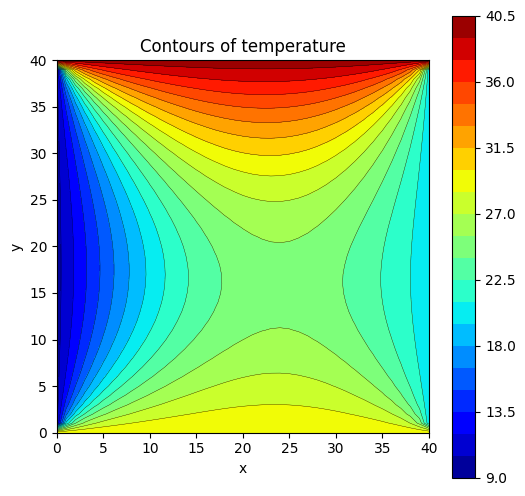

In [56]:
# Função para modificar a matriz e incorporar as condições de borda
def BuildSystemSim(N, TL, TR, TB, TT):
    nunk = N**2
    A = MatAssembly(N)
    Atilde = A.copy()
    b = np.zeros(shape=(nunk))
    k = np.array(range(0,N))
    Iden = np.identity(nunk)

    Ic = ij2n(0,k,N) # Tleft
    for r in k:
        b[:] = b[:] - A[:,Ic[r]]*TL 
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TL
    Atilde[:,Ic] = Iden[:,Ic]

    Ic = ij2n(N-1,k,N) # Tright
    for r in k:
        b[:] = b[:] - A[:,Ic[r]]*TR
    #somente os termos b[Ic[k]] com k variando de 0 a N-1, correspondentes a uma borda,
    #tem a temperatura dessa respectiva borda
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TR
    Atilde[:,Ic] = Iden[:,Ic]
    
    Ic = ij2n(k,0,N) # Tbottom
    for r in k:
        b[:] = b[:] - A[:,Ic[r]]*TB 
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TB
    Atilde[:,Ic] = Iden[:,Ic]

    Ic = ij2n(k,N-1,N) # Ttop
    for r in k:
        b[:] = b[:] - A[:,Ic[r]]*TT
    Atilde[Ic,:], b[Ic] = Iden[Ic,:], TT
    Atilde[:,Ic] = Iden[:,Ic]
    
    return Atilde, b

N = 41
Atilde, b = BuildSystemSim(N, TL=10.0, TR=20.0, TB=30.0, TT=40.0)
print(np.linalg.norm(Atilde-Atilde.T))

T = scipy.linalg.solve(Atilde,b)
Tplot = T.copy().reshape(N,N).T
PlotaTemperature(N,N,Tplot)

## 2 - Método Iterativo

In [57]:
def iterativ_metod_1(N,TL, TR, TB, TT,Nmax,tol):
    A,b=BuildSystem(N,TL, TR, TB, TT)
    M=np.zeros(shape=(N**2,N**2))
    for i in range(0,N**2):
        M[i][i]=A[i][i]
    cold=b.copy() #primeiro chute para x é um vetor b
    cnew=b.copy()    
    r=A@cold-b
    k=0
    while(k<Nmax and np.linalg.norm(r)>tol):
        d=np.linalg.solve(M,-r)
        e=1
        cnew=cold+(e*d)
        r=A@cnew-b
        cold=cnew.copy() #atualiza o chute 
        k=k+1
    return k #retorma o número de interaçõies necessárias

def iterativ_metod_2(N,TL, TR, TB, TT,Nmax,tol):
    A,b=BuildSystem(N,TL, TR, TB, TT)
    M=np.triu(A)
    cold=b.copy()*0 #primeiro chute para x é um vetor b
    cnew=b.copy()*0    
    r=A@cold-b
    k=0
    while(k<Nmax and np.linalg.norm(r)>tol):
        d=np.linalg.solve(M,-r)
        e=1
        cnew=cold+(e*d)
        r=A@cnew-b
        cold=cnew.copy() #atualiza o chute 
        k=k+1
    return k #retorma o número de interaçõies necessárias

def iterativ_simetricmetod_1(N,TL, TR, TB, TT,Nmax,tol):
    A,b=BuildSystemSim(N,TL, TR, TB, TT)
    M=np.zeros(shape=(N**2,N**2))
    for i in range(0,N**2):
        M[i][i]=A[i][i]
    cold=b.copy() #primeiro chute para x é um vetor b
    cnew=b.copy()    
    r=A@cold-b
    k=0
    while(k<Nmax and np.linalg.norm(r)>tol):
        d=np.linalg.solve(M,-r)
        e=1
        cnew=cold+(e*d)
        r=A@cnew-b
        cold=cnew.copy() #atualiza o chute 
        k=k+1
    return k #retorma o número de interaçõies necessárias

def iterativ_simetricmetod_2(N,TL, TR, TB, TT,Nmax,tol):
    A,b=BuildSystemSim(N,TL, TR, TB, TT)
    M=np.triu(A)
    cold=b.copy()*0 #primeiro chute para x é um vetor b
    cnew=b.copy()*0    
    r=A@cold-b
    k=0
    while(k<Nmax and np.linalg.norm(r)>tol):
        d=np.linalg.solve(M,-r)
        e=1
        cnew=cold+(e*d)
        r=A@cnew-b
        cold=cnew.copy() #atualiza o chute 
        k=k+1
    return k #retorma o número de interaçõies necessárias

## 3 - Execução do programa

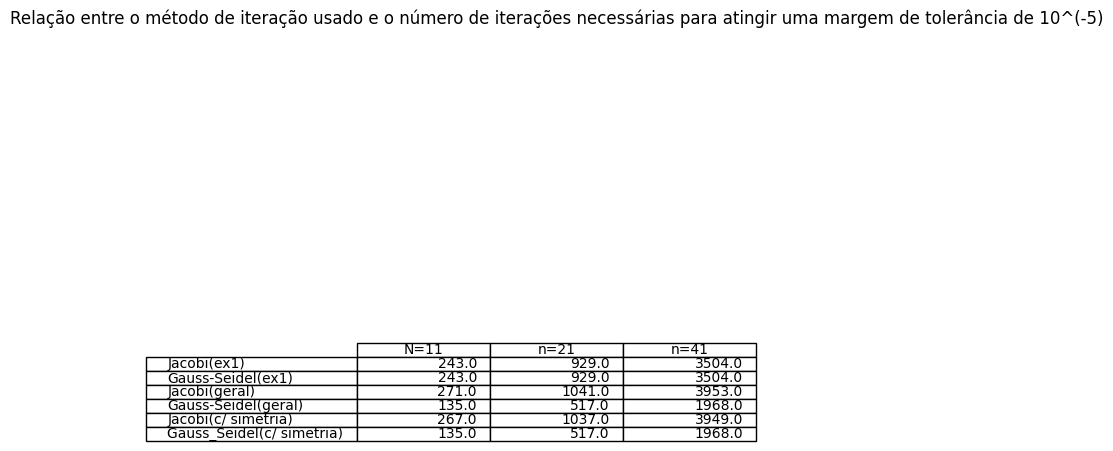

In [58]:
relacao=np.zeros(shape=(6,3))
N=np.array(3)
N=[11,21,41]
for i in range (0,len(N)):
    relacao[0][i]=metod_jacobi(N[i],0.0,0.0,0.0,20.0,10000,10**(-5))
    relacao[1][i]=metod_jacobi(N[i],0.0,0.0,0.0,20.0,10000,10**(-5))
    relacao[2][i]=iterativ_metod_1(N[i],0.0,0.0,0.0,20.0,10000,10**(-5))
    relacao[3][i]=iterativ_metod_2(N[i],0.0,0.0,0.0,20.0,10000,10**(-5))
    relacao[4][i]=iterativ_simetricmetod_1(N[i],0.0,0.0,0.0,20.0,10000,10**(-5))
    relacao[5][i]=iterativ_simetricmetod_2(N[i],0.0,0.0,0.0,20.0,10000,10**(-5))
colunas=np.array(['N=11','n=21','n=41'],dtype=str)
linhas=np.array(['Jacobi(ex1)','Gauss-Seidel(ex1)','Jacobi(geral)','Gauss-Seidel(geral)','Jacobi(c/ simetria)','Gauss_Seidel(c/ simetria)'],dtype=str)
plot_table(relacao,colunas,linhas)